# Why Are Our Customers Churning
## *Insights from analysis of Telco customer data*

### Kevin Eliasen, Bayes Cohort

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import PercentFormatter

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LassoCV

from datetime import datetime


import warnings
warnings.filterwarnings("ignore")


In [2]:
import acquire as acq
import prepare as prep

from debug import local_settings, timeifdebug, timeargsifdebug, frame_splain, get_date_time_code
from acquire import get_telco_data
from prepare import DFO

### Set local settings

In [3]:
from debug import local_settings

# local_settings.splain=True
# local_settings.debug=True
splain = local_settings.splain
debug = local_settings.debug

In [4]:
    df = get_telco_data(splain=splain)
    df = df.set_index('customer_id')

In [5]:
frame_splain(df,splain=True)

DATAFRAME SHAPE:
(7043, 50) 

DATAFRAME INFO:
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0003-MKNFE to 9995-HOTOH
Data columns (total 50 columns):
gender                      7043 non-null object
is_male                     7043 non-null int64
is_female                   7043 non-null int64
senior_citizen              7043 non-null int64
partner                     7043 non-null int64
dependents                  7043 non-null int64
family                      7043 non-null int64
partner_deps_id             7043 non-null int64
partner_deps                7043 non-null object
tenure                      7043 non-null int64
tenure_years                7043 non-null int64
contract_renews             7043 non-null int64
remaining_months            7043 non-null int64
thru_first_month            7043 non-null int64
thru_first_quarter          7043 non-null int64
thru_first_half             7043 non-null int64
thru_first_year             7043 non-null int64
thru_first_term    

#### Prep Function: retype_cols

In [6]:
@timeifdebug
def retype_cols(df, cols, to_dtype, **kwargs):
    '''
    retype_cols(df, columns, to_dtype, **kwargs)
    RETURNS df with updated column types
    
    Function first checks to ensure columns are in dataframe.
    '''
    for col in (xcol for xcol in columns if xcol in df.columns):
        df[col] = df[col].astype(to_dtype)
    
    # print(dataframe.dtypes)
    return df

### Identify and re-type categorical columns

In [7]:
category_cols=[
    'partner_deps_id',
    'partner_deps',
    'gender',
    'contract_type_id',
    'internet_service_type_id',
    'internet_service_type',
    'contract_type',
    'payment_type_id',
    'payment_type',
    'phone_service_type',
    'phone_service_id'
]

In [8]:
df = prep.retype_cols(df=df, cols=category_cols, to_dtype='category')

### Identify and re-type boolean columns

In [9]:
boolean_cols  = [
    'is_male',
    'is_female',
    'senior_citizen',
    'partner',
    'dependents',
    'family',
    'thru_first_month',
    'thru_first_quarter',
    'thru_first_half',
    'thru_first_year',
    'thru_first_term',
    'phone_service',
    'multiple_lines',
    'internet_service',
    'has_dsl',
    'has_fiber',
    'online_security',
    'online_backup',
    'online_security_backup',
    'device_protection',
    'tech_support',
    'streaming_tv',
    'streaming_movies',
    'streaming_services',
    'streaming_dsl',
    'streaming_fiber',
    'on_contract',
    'paperless_billing',
    'manual_mtm',
    'auto_pay'
]

In [10]:
df = prep.retype_cols(df=df, cols=boolean_cols, to_dtype='bool')

### Identify columns with text values (to be pulled prior to modeling)

In [11]:
string_cols = [
    'partner_deps',
    'gender',
    'internet_service_type',
    'contract_type',
    'payment_type',
    'phone_service_type',
]

### Populate dataframe object (DFO) with prep data

In [12]:
#dfo = prep.set_dfo(dfo_df=df, y_column='churn', splain=True)

In [13]:
dfo = prep.prep_telco_churn_data(splain=local_settings.splain)

In [14]:
frame_splain(dfo.df, splain=True)

DATAFRAME SHAPE:
(7043, 50) 

DATAFRAME INFO:
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0003-MKNFE to 9995-HOTOH
Data columns (total 50 columns):
gender                      7043 non-null category
is_male                     7043 non-null bool
is_female                   7043 non-null bool
senior_citizen              7043 non-null bool
partner                     7043 non-null bool
dependents                  7043 non-null bool
family                      7043 non-null bool
partner_deps_id             7043 non-null category
partner_deps                7043 non-null category
tenure                      7043 non-null int64
tenure_years                7043 non-null int64
contract_renews             7043 non-null int64
remaining_months            7043 non-null int64
thru_first_month            7043 non-null bool
thru_first_quarter          7043 non-null bool
thru_first_half             7043 non-null bool
thru_first_year             7043 non-null bool
thru_first_term       

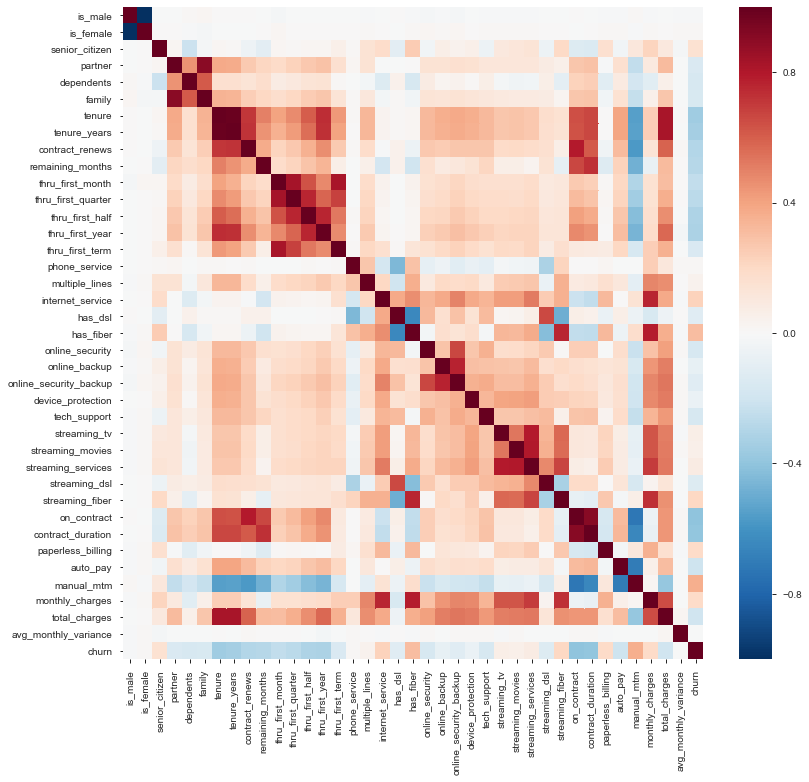

In [15]:
prep.heatmap_train(df, show_now=True, annot=False)

In [16]:
# prep.pairplot_train(df, show_now=True)

### Null and Non-Conforming Values

11 rows had non-numeric values in the `total_charges` field. On closer examination, it turned out that these represented new customers who have a tenure of zero and have not incurred their first monthly charge. 

In [17]:
df[df.tenure == 0]

,gender,is_male,is_female,senior_citizen,partner,dependents,family,partner_deps_id,partner_deps,tenure,...,contract_duration,paperless_billing,payment_type_id,payment_type,auto_pay,manual_mtm,monthly_charges,total_charges,avg_monthly_variance,churn
customer_id,,,,,,,,,,,,,,,,,,,,,
1371-DWPAZ,Female,False,True,False,True,True,True,3,"Has partner, has dependents",0,...,24,False,4,Credit card (automatic),True,False,56.05,0.0,0.0,0
2923-ARZLG,Male,True,False,False,True,True,True,3,"Has partner, has dependents",0,...,12,True,2,Mailed check,False,False,19.70,0.0,0.0,0
2520-SGTTA,Female,False,True,False,True,True,True,3,"Has partner, has dependents",0,...,24,False,2,Mailed check,False,False,20.00,0.0,0.0,0
2775-SEFEE,Male,True,False,False,False,True,True,1,"No partner, has dependents",0,...,24,True,3,Bank transfer (automatic),True,False,61.90,0.0,0.0,0
3115-CZMZD,Male,True,False,False,False,True,True,1,"No partner, has dependents",0,...,24,False,2,Mailed check,False,False,20.25,0.0,0.0,0
3213-VVOLG,Male,True,False,False,True,True,True,3,"Has partner, has dependents",0,...,24,False,2,Mailed check,False,False,25.35,0.0,0.0,0
4075-WKNIU,Female,False,True,False,True,True,True,3,"Has partner, has dependents",0,...,24,False,2,Mailed check,False,False,73.35,0.0,0.0,0
4367-NUYAO,Male,True,False,False,True,True,True,3,"Has partner, has dependents",0,...,24,False,2,Mailed check,False,False,25.75,0.0,0.0,0
4472-LVYGI,Female,False,True,False,True,True,True,3,"Has partner, has dependents",0,...,24,True,3,Bank transfer (automatic),True,False,52.55,0.0,0.0,0


The small size of this group made it irrelevent whether they were kept or discarded from the data set. I chose to keep them, and set the value at zero - the amount they have been charged thusfar.

Any calculations regarding average monthly amounts for these customers will use their stated monthly_charges value.

All these activities are captured in the SQL statement.

In [18]:
@timeifdebug
def remove_cols(df, cols, **kwargs):
    '''
    remove_cols(dataframe, columns, **kwargs)
    RETURNS dataframe with columns removed
    
    Function first checks to ensure columns are in dataframe.
    '''
    dropcols = [col for col in cols if col in df.columns]
    if len(dropcols):
        df = df.drop(columns=dropcols)    
    return df

In [19]:
# df2 = acq.check_df(dfo.train)
# df2 is df

In [20]:
# df2 = drop_cols(df=df2, cols=string_cols)
# frame_splain(df2, splain=True)

In [21]:
dfo = prep.split_dfo(
    dfo, 
    train_pct=.7, 
    randomer=123456789, 
    stratify=dfo.y_column, 
    drop_cols=string_cols, 
    splain=splain
)

In [22]:
dfo = prep.scale_dfo(
    dfo, 
    scaler_fn=None, 
    splain=splain
)

In [23]:
X_train = dfo.X_train
y_train = dfo.y_train
X_test = dfo.X_test
y_test = dfo.y_test

In [24]:
X_train

,is_male,is_female,senior_citizen,partner,dependents,family,partner_deps_id,tenure,tenure_years,contract_renews,...,on_contract,contract_duration,paperless_billing,payment_type_id,auto_pay,manual_mtm,monthly_charges,total_charges,avg_monthly_variance,dummy_val
customer_id,,,,,,,,,,,,,,,,,,,,,
5138-WVKYJ,True,False,False,False,False,False,0,10,0,0,...,False,1,False,1,False,True,98.55,1008.55,2.31,1
4950-BDEUX,True,False,False,False,False,False,0,35,2,0,...,False,1,False,1,False,True,49.20,1701.65,-0.58,1
0376-OIWME,True,False,False,True,False,True,2,36,3,0,...,False,1,True,1,False,True,93.60,3366.05,-0.10,1
2911-UREFD,False,True,False,True,False,True,2,39,3,0,...,False,1,False,1,False,True,55.90,2184.35,0.11,1
9283-LZQOH,True,False,False,True,True,True,3,13,1,0,...,False,1,True,4,True,False,74.40,896.75,-5.42,1
8903-XEBGX,True,False,False,False,True,True,1,2,0,0,...,False,1,True,1,False,True,55.30,108.65,-0.97,1
5747-PMBSQ,True,False,True,True,False,True,2,10,0,0,...,False,1,True,2,False,True,92.50,934.10,0.91,1
7742-MYPGI,False,True,False,True,True,True,3,6,0,0,...,False,1,True,2,False,True,48.80,297.35,0.76,1
7963-GQRMY,False,True,False,True,True,True,3,3,0,0,...,False,1,False,2,False,True,44.30,134.50,0.53,1


In [25]:
cor = dfo.df.corr()


In [26]:
y_cor = pd.DataFrame(cor.loc[:,dfo.y_column])

In [27]:
y_cor['abs_r']=abs(y_cor[dfo.y_column])
y_cor.sort_values(by='abs_r', ascending=False)

,churn,abs_r
churn,1.000000,1.000000
on_contract,-0.405103,0.405103
contract_duration,-0.394453,0.394453
manual_mtm,0.361447,0.361447
tenure,-0.352229,0.352229
tenure_years,-0.342196,0.342196
thru_first_year,-0.317666,0.317666
thru_first_half,-0.308773,0.308773
has_fiber,0.308020,0.308020
contract_renews,-0.296325,0.296325


In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

from sklearn.ensemble import RandomForestClassifier


## Decision Tree

In [64]:
# for classification you can change the algorithm to gini or entropy (information gain).  Default is gini.
dtc = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=4, 
    min_samples_leaf=5, 
    min_samples_split=10,
    random_state=dfo.randomer, 
    # max_features=len(dfo.train.columns)-1
    max_features=12
)


In [65]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
                       max_features=12, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123456789, splitter='best')

In [66]:
y_pred_dtc_tr = dtc.predict(X_train)
y_pred_dtc_tr_proba = dtc.predict_proba(X_train)
y_pred_dtc_tr_proba

array([[0.35121951, 0.64878049],
       [0.78225806, 0.21774194],
       [0.51480638, 0.48519362],
       ...,
       [0.75      , 0.25      ],
       [0.93379791, 0.06620209],
       [0.69451697, 0.30548303]])

In [67]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(dtc.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(dtc.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 0.79
Accuracy of Decision Tree classifier on test set: 0.79


In [68]:
confusion_matrix(y_train, y_pred_dtc_tr)

array([[3438,  419],
       [ 690,  735]])

In [79]:
print(classification_report(y_train, y_pred_dtc_tr))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      3857
           1       0.64      0.52      0.57      1425

    accuracy                           0.79      5282
   macro avg       0.73      0.70      0.72      5282
weighted avg       0.78      0.79      0.78      5282



In [70]:
recall_score(y_train, y_pred_dtc_tr)

0.5157894736842106

In [71]:
y_pred_dtc_ts = dtc.predict(X_test)
y_pred_dtc_ts_proba = dtc.predict_proba(X_test)
y_pred_dtc_ts_proba

array([[0.97050147, 0.02949853],
       [0.93379791, 0.06620209],
       [0.9841629 , 0.0158371 ],
       ...,
       [0.35121951, 0.64878049],
       [0.93379791, 0.06620209],
       [0.49575071, 0.50424929]])

In [72]:
print(classification_report(y_test, y_pred_dtc_ts))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1317
           1       0.61      0.49      0.54       444

    accuracy                           0.79      1761
   macro avg       0.72      0.69      0.71      1761
weighted avg       0.78      0.79      0.78      1761



In [73]:
confusion_matrix(y_test, y_pred_dtc_ts)

array([[1176,  141],
       [ 225,  219]])

In [74]:
recall_score(y_test, y_pred_dtc_ts)

0.49324324324324326

## *Optimize for recall*

## Recall = False Negatives = *surprise dollars lost*

In [75]:
col_vital_dtc = pd.DataFrame(X_train.columns, columns=['column'])
col_vital_dtc['importance'] = dtc.feature_importances_
col_vital_dtc.sort_values(by='importance', ascending=False)

,column,importance
9,contract_renews,0.529839
22,has_fiber,0.182110
7,tenure,0.088190
13,thru_first_half,0.060473
20,internet_service,0.059235
19,internet_service_type_id,0.022515
41,total_charges,0.021439
37,payment_type_id,0.017045
29,streaming_movies,0.013867
38,auto_pay,0.003085


In [76]:
def get_date_time_code(datetime=datetime.now(), in_format='%Y%d%m%H%M'):
    return datetime.strftime(in_format)



In [77]:
import graphviz

from graphviz import Graph

dot_data = export_graphviz(dtc, out_file=None) 
graph = graphviz.Source(dot_data) 
file_name = 'telco_churn_decision_tree_' + get_date_time_code()
graph.render(file_name , view=True)

'telco_churn_decision_tree_201930101255.pdf'

## Random Forest

In [43]:
rfc = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=5,
                            n_estimators=10000,
                            max_depth=None, 
                            random_state=dfo.randomer)

rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=None, oob_score=False, random_state=123456789,
                       verbose=0, warm_start=False)

In [44]:
y_pred_rfc_tr = rfc.predict(X_train)
y_pred_rfc_tr_proba_ = rfc.predict_proba(X_train)
y_pred_rfc_tr_proba_

array([[0.33440309, 0.66559691],
       [0.75632338, 0.24367662],
       [0.69924922, 0.30075078],
       ...,
       [0.94078553, 0.05921447],
       [0.7548854 , 0.2451146 ],
       [0.66518421, 0.33481579]])

In [45]:
y_pred_rfc_ts = rfc.predict(X_test)
y_pred_rfc_ts_proba_ = rfc.predict_proba(X_test)
y_pred_rfc_ts_proba_

array([[0.98756897, 0.01243103],
       [0.93246612, 0.06753388],
       [0.98840316, 0.01159684],
       ...,
       [0.3402172 , 0.6597828 ],
       [0.97130659, 0.02869341],
       [0.58258599, 0.41741401]])

In [46]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rfc.score(X_train, y_train)))
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rfc.score(X_test, y_test)))

Accuracy of random forest classifier on training set: 0.87
Accuracy of random forest classifier on test set: 0.81


In [47]:
confusion_matrix(y_train, y_pred_rfc_tr)

array([[3660,  197],
       [ 495,  930]])

In [48]:
print(classification_report(y_train, y_pred_rfc_tr))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      3857
           1       0.83      0.65      0.73      1425

    accuracy                           0.87      5282
   macro avg       0.85      0.80      0.82      5282
weighted avg       0.87      0.87      0.86      5282



In [49]:
print(classification_report(y_test, y_pred_rfc_ts))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1317
           1       0.66      0.50      0.57       444

    accuracy                           0.81      1761
   macro avg       0.76      0.71      0.73      1761
weighted avg       0.80      0.81      0.80      1761



In [50]:
confusion_matrix(y_test, y_pred_rfc_ts)

array([[1204,  113],
       [ 220,  224]])

In [51]:
col_imps_rfc = pd.DataFrame(X_train.columns, columns=['column'])
col_imps_rfc['importance'] = rfc.feature_importances_
col_imps_rfc.sort_values(by='importance', ascending=False)

,column,importance
40,monthly_charges,0.091532
7,tenure,0.081474
41,total_charges,0.081265
35,contract_duration,0.057508
33,contract_type_id,0.056693
42,avg_monthly_variance,0.054308
34,on_contract,0.053707
22,has_fiber,0.041095
9,contract_renews,0.038203
37,payment_type_id,0.034818


In [52]:
from datetime import datetime
from datetime import date

now = datetime.now() # current date and time
# now = date(2004, 1, 4)
year = now.strftime("%Y")
# print("year:", year)
month = now.strftime("%m")
# print("month:", month)
day = now.strftime("%d")
# print("day:", day)
time = now.strftime("%H:%M:%S")
# print("time:", time)
date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
# print("date and time:",date_time)
date_code = now.strftime('%Y%d%m%H%M')
print('date string:', date_code)

date string: 201930101254


In [53]:
from math import sqrt
from scipy import stats

In [54]:
@timeifdebug
def bool_ttest_single(df, target_column='target', column_list=[], alpha=.05, **kwargs):

    p_list = []
    col_name = target_column
    for col in column_list:
        is_true = df[df[col] == True]
        y_if_true = is_true[col_name].mean()
        y_mean = df[col_name].mean()
        t, p = stats.ttest_1samp(is_true.churn, df.churn.mean())
        p_list.append([col, t, p, p<alpha, y_if_true, y_mean])
    df_p = pd.DataFrame(p_list, columns=['column','t_stat','p_value','is_sig', col_name + '_if_true', col_name + '_mean']).set_index('column').sort_values(by='p_value')
    return df_p

In [55]:
bool_ttest_single(df, target_column=dfo.y_column, column_list=boolean_cols, alpha=.05, debug=True)

,t_stat,p_value,is_sig,churn_if_true,churn_mean
column,,,,,
on_contract,-44.357379,0.000000e+00,True,0.067551,0.26537
manual_mtm,20.977105,9.834187e-91,True,0.465184,0.26537
has_fiber,17.314802,3.499910e-64,True,0.418928,0.26537
thru_first_year,-16.792290,1.345522e-61,True,0.174910,0.26537
auto_pay,-15.947221,4.602521e-55,True,0.159817,0.26537
online_security,-15.167170,2.736199e-49,True,0.146112,0.26537
tech_support,-14.328306,1.924588e-44,True,0.151663,0.26537
dependents,-14.087009,3.867317e-43,True,0.154502,0.26537
streaming_fiber,12.802907,3.042072e-36,True,0.399361,0.26537


In [56]:
#     stats.ttest_ind(x1, x2)
@timeifdebug
def bool_ttest_multi(df, target_column='target', column_list=[], alpha=.05, **kwargs):
    col_name = target_column
    p_list = []
    for col in column_list:
        is_true = df[df[col] == True][col_name]
        is_not = df[df[col] != True][col_name]
        y_if_true = is_true.mean()
        y_if_not = is_not.mean()
        t, p = stats.ttest_ind(is_true, is_not)
        p_list.append([col, t, p, p<alpha, y_if_true, y_if_not])

    df_p2 = pd.DataFrame(p_list, columns=['column','t_stat','p_value','is_sig', col_name + '_if_true', col_name + '_if_not']).set_index('column').sort_values(by='p_value')
    return df_p2

In [57]:
bool_ttest_multi(df, target_column=dfo.y_column, column_list=boolean_cols, alpha=.05, debug=True)

,t_stat,p_value,is_sig,churn_if_true,churn_if_not
column,,,,,
on_contract,-37.179843,1.991701e-276,True,0.067551,0.427097
manual_mtm,32.528445,2.316325e-216,True,0.465184,0.137907
thru_first_year,-28.111672,6.867572e-165,True,0.174910,0.482842
thru_first_half,-27.240469,1.963339e-155,True,0.198343,0.542670
has_fiber,27.167003,1.200784e-154,True,0.418928,0.144920
thru_first_quarter,-23.444713,4.179258e-117,True,0.221000,0.583527
thru_first_month,-20.986995,6.624254e-95,True,0.231968,0.608974
internet_service,19.639210,1.200504e-83,True,0.318289,0.074050
auto_pay,-18.014338,5.789070e-71,True,0.159817,0.346744


## Churn Rates by Tenure

In [58]:
@timeifdebug
def cumulative_target_analysis(
    df, 
    target_col='target', 
    feature_cal='feature', 
    target_val=True, 
    target_val_str='true',
    idx_numeric=True,
    **kwargs
):
    target_col = dfo.y_column
    target_val = True
    target_val_str = 'true'
    feature_col = 'tenure'
    use_df = dfo.train
    tot_custs = len(use_df)
    target_feature_label = feature_col + '_' + target_col + '_is_' + target_val_str
    total_feature_label = feature_col + '_count'
    eligible_feature_label = feature_col + '_eligible_count'
    eligible_rate_label = feature_col + '_' + target_col + '_rate'
    cumulative_target_label = 'cumulative_' + target_col + '_is_' + target_val_str
    cumulative_rate_label = 'cumulative_' + target_col + '_rate'

    true_df = use_df[use_df[target_col] == target_val]

    target_vals = (true_df[feature_col]
                 .value_counts()
                 .reset_index()
                 .rename(columns={feature_col: target_feature_label})
                 .rename(columns={'index': feature_col})
                .sort_values(by=feature_col)
                )

    eligible_vals = (use_df[feature_col]
                .value_counts()
                .reset_index()
                .rename(columns={feature_col: eligible_feature_label})
                .rename(columns={'index': feature_col})
                .sort_values(by=feature_col)
               )
    
    if idx_numeric:
        eligible_max = use_df[feature_col].max()
        master_df = pd.DataFrame(np.arange(eligible_max + 1), columns=[feature_col])
        merge_df = (pd
                   .merge(master_df, eligible_vals, on=feature_col, how='left')
                   .fillna(value=0)
                   .astype('int64')
                   .sort_values(by=feature_col)
                   .set_index(feature_col))
    else:
        merge_df = eligible_vals
    

    merge_df = (pd
               .merge(merge_df, target_vals, on=feature_col, how='left')
               .fillna(value=0)
               .astype('int64')
               .sort_values(by=feature_col)
               .set_index(feature_col))

    merge_df = merge_df[[target_feature_label, eligible_feature_label]]

    tot_pop = []
    cur_pop = tot_custs

    for mo in merge_df[eligible_feature_label]:
        tot_pop.append(cur_pop)
        cur_pop -= mo

    tot_true = []
    tot_trues = 0    
    for mo in merge_df[target_feature_label]:
        tot_trues += mo
        tot_true.append(tot_trues)

    merge_df[eligible_feature_label] = tot_pop
    merge_df[eligible_rate_label] = merge_df[target_feature_label] / merge_df[eligible_feature_label]
    merge_df[cumulative_target_label] = tot_true
    merge_df[cumulative_rate_label] = merge_df[cumulative_target_label] / tot_custs
    return merge_df



# tenure_churns = dfo.train[dfo.train.]

In [59]:
cta = cumulative_target_analysis(
    df=dfo.train, 
    target_col=dfo.y_column, 
    feature_cal='tenure', 
    target_val=True, 
    target_val_str='true',
    idx_numeric=False,
    debug=True)

cta

,tenure_churn_is_true,tenure_eligible_count,tenure_churn_rate,cumulative_churn_is_true,cumulative_churn_rate
tenure,,,,,
0,0,5282,0.000000,0,0.000000
1,293,5277,0.055524,293,0.055471
2,95,4812,0.019742,388,0.073457
3,69,4632,0.014896,457,0.086520
4,64,4477,0.014295,521,0.098637
5,50,4343,0.011513,571,0.108103
6,30,4242,0.007072,601,0.113783
7,38,4161,0.009132,639,0.120977
8,34,4054,0.008387,673,0.127414


In [60]:
cta[['tenure_churn_rate','cumulative_churn_rate']]

,tenure_churn_rate,cumulative_churn_rate
tenure,,
0,0.000000,0.000000
1,0.055524,0.055471
2,0.019742,0.073457
3,0.014896,0.086520
4,0.014295,0.098637
5,0.011513,0.108103
6,0.007072,0.113783
7,0.009132,0.120977
8,0.008387,0.127414


In [61]:
@timeifdebug
def cumulative_target_plot(
    df, 
    current_column='bar_graph', 
    cumulative_column='perato_graph', 
    **kwargs
    ):
    
    fig, ax = plt.subplots()
    ax.bar(df.index, df[current_column], color="C0")
    ax.yaxis.set_major_formatter(PercentFormatter())
    ax2 = ax.twinx()
    ax2.plot(df.index, df[cumulative_column], color="C1", ms=7)
    ax2.yaxis.set_major_formatter(PercentFormatter())

    ax.tick_params(axis="y", colors="C0")
    ax2.tick_params(axis="y", colors="C1")
    plt.show()

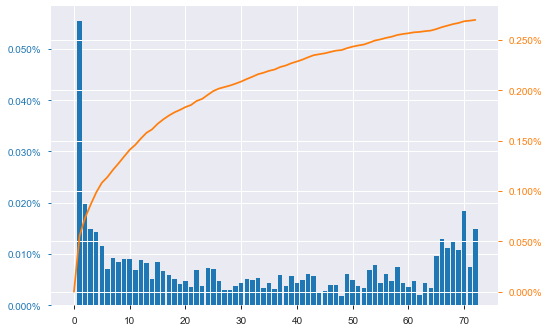

In [62]:
cta_plot = cumulative_target_plot(
    df=cta, 
    current_column='tenure_churn_rate', 
    cumulative_column='cumulative_churn_rate', 
    debug=True)

### Data Dictionary

Field Name|Data in field|Data Type
:--- | :--- | :---
**customer_id**|Unique identifier *Turned into index*|object
**gender**|'Male' or 'Female'|category
**is_male**|True if is gender = 'Male'|bool
**is_female**|True  if gender = 'Female'|bool
**senior_citizen**|True  if customer is a senior citizen|bool
**partner**|True  if customer has a partner|bool
**dependents**|True  if customer has dependents|bool
**family**|True if customer has a partner and/or has dependents|bool
**partner_deps**|Categorical, 'has' or 'no' for partner and dependents|category
**tenure**|Number of months customer has been active; remains static once customer has churned|Int64
**tenure_years**|Number of complete years customer has been active; remains static once customer has churned|Int64
**contract_renews**|Number of times customer has exceeded their term length if not month-to-month|Int64
**remaining_months**|Months remaining on current contract|int64
**thru_first_month**|True if customer has a tenure greater than 1|bool
**thru_first_quarter**|True if customer has a tenure greater than 2|bool
**thru_first_half**|True if customer has a tenure greater than 5|bool
**thru_first_year:**|True if customer has a tenure greater than 11|bool
**thru_first_term**|True if customer has exceeded a full term of their contract|bool
**phone_service**|True if customer has phone service|bool
**multiple_lines**|True if customer has multiple lines|bool
**phone_service_id**|Categorical, numeric ID for type of phone service|category
**phone_service_type**|Categorical, description of phone service type|category
**internet_service_type_id**|Categorical, numeric ID for type of phone service|category
**internet_service_type**|Categorical, description of internet service type|category
**internet_service**|True if customer has an internet service type|bool
**has_dsl**|True if customer has DSL internet service|bool
**has_fiber**|True if customer has Fiber Optic internet service|bool
**online_security**|True if custmer registerd for online security|bool
**online_backup**|True if customer registered for online backup|bool
**online_security_backup**|True if customer registered for online security and/or online backup|bool
**device_protection**|True if customer registered for device protections|bool
**tech_support**|True if customer registered for tech support|bool
**streaming_tv**|True if customer registered for streaming TV channels|bool
**streaming_movies**|True if customer registered for streaming movies|bool
**streaming_services**|True if customer registered for streaming TV channels and/or movies|bool
**streaming_dsl**|True if customer has DSL internet service and registered for streaming TV channels and/or movies|bool
**streaming_fiber**|True if customer has DSL internet service and registered for streaming TV channels and/or movies|bool
**contract_type_id**|Categorical, numeric ID for type of contract (1 = month-to-month, 2 = annual, 3 = two-year)|category
**contract_type**|Categorical, descriptive ID for type of contract|category
**on_contract**|True if customer has an annual or two-year contract|bool
**contract_duration**|Customer's contractual term in months (1, 12, or 24)|int64
**paperless_billing**|True if customer registered for paperless billing|bool
**payment_type_id**|Categorical, numeric ID for method of payment|category
**payment_type**|Categorical, description of method of payment and indicator if payment method is automatic|category
**auto_pay**|True if customer payment type is defined as automatic|bool
**manual_mtm**|True if payment is not automatic and customer is not on contract|bool
**monthly_charges**|Current monthly charges for customer|float
**avg_monthly_variance**|Calculated difference between projected monthly rate based on total charges and stated monthly rate|float
**churn**|True if customer has churned. *Target variable.*|bool

### SQL Statement:

In [63]:
sql = '''
select
    cust.customer_id,
    cust.gender,
    cust.gender = 'Male' is_male,
    cust.gender = 'Female' is_female,
    cust.senior_citizen,
    cust.partner = 'Yes' partner,
    cust.dependents = 'Yes' dependents,
    cust.partner = 'Yes' or cust.dependents = 'Yes' family,
    (case when cust.partner = 'Yes' 
        then 1 else 0 
        end * 2) + 
    case when cust.dependents = 'Yes' 
        then 1 else 0 
        end partner_deps_id,
    concat(
        case when cust.partner = 'Yes' 
            then 'Has ' else 'No ' 
            end,
        'partner, ',
        case when cust.dependents = 'Yes' 
            then 'has ' else 'no ' 
            end,
        'dependents') partner_deps,
    cust.tenure,
    (cust.tenure DIV 12) tenure_years,
    case when cust.contract_type_id = 1 
        then 0 else (cust.tenure DIV 
        case when cust.contract_type_id = 2 
            then 12 else 24 
            end) 
        end contract_renews,
    case when cust.contract_type_id = 1 
        then 0 else (cust.tenure MOD 
        case when cust.contract_type_id = 2 
            then 12 else 24 
            end) 
        end remaining_months,
    cust.tenure > 1 thru_first_month,
    cust.tenure >= 3 thru_first_quarter,
    cust.tenure >= 6 thru_first_half,
    cust.tenure >= 12 thru_first_year,
    cust.tenure > 
        case when cust.contract_type_id = 1 
            then 1 else 
            case when cust.contract_type_id = 2 
                then 12 else 24 
            end 
        end thru_first_term,
    cust.phone_service = 'Yes' phone_service,
    cust.multiple_lines = 'Yes' multiple_lines,
    case when cust.phone_service = 'Yes' 
        then 1 + 
        case when cust.multiple_lines = 'Yes' 
            then 1 else 0 
            end 
        else 0 
        end phone_service_id,
    case when cust.phone_service = 'Yes' 
        then 
        case when cust.`multiple_lines` = 'Yes' 
            then 'Multiple Lines' else 'Single Line' 
            end 
        else 'No Phone' 
        end phone_service_type,
    cust.internet_service_type_id,
    ist.internet_service_type,
    cust.internet_service_type_id <> 3 internet_service,
    cust.internet_service_type_id = 1 has_dsl,
    cust.internet_service_type_id = 2 has_fiber,
    cust.online_security = 'Yes' online_security,
    cust.online_backup = 'Yes' online_backup,
    cust.online_security = 'Yes' or cust.online_backup = 'Yes' online_security_backup,
    cust.device_protection = 'Yes' device_protection,
    cust.tech_support = 'Yes' tech_support,
    cust.streaming_tv = 'Yes' streaming_tv,
    cust.streaming_movies = 'Yes' streaming_movies,
    cust.streaming_tv = 'Yes' or streaming_movies = 'Yes' streaming_services,
    cust.internet_service_type_id = 1 and 
        (cust.streaming_tv = 'Yes' or streaming_movies = 'Yes') streaming_dsl,
    cust.internet_service_type_id = 2 and 
        (cust.streaming_tv = 'Yes' or streaming_movies = 'Yes') streaming_fiber,
    cust.contract_type_id,
    ct.contract_type,
    cust.contract_type_id <> 1 on_contract,
    case when cust.contract_type_id = 1 
        then 1 else 
        case when cust.contract_type_id = 2 
            then 12 else 24 
            end 
        end contract_duration,
    cust.paperless_billing = 'Yes' paperless_billing,
    cust.payment_type_id,
    pt.payment_type,
    pt.payment_type like '%%auto%%' auto_pay,
    pt.payment_type not like '%%auto%%' and cust.contract_type_id = 1 manual_mtm,
    cust.monthly_charges,
    case when cust.total_charges = '' 
        then 0 else cast(cust.total_charges as decimal(11,2)) 
        end total_charges,
    cast(
        case when cust.tenure = 0 
            then 0 else ((cast(
                cust.total_charges as decimal(11,2)
                ) / cust.tenure) - cust.monthly_charges) 
            end as decimal(11,2)
        ) avg_monthly_variance,
    case when cust.churn = 'Yes' 
        then 1 else 0 
        end churn
from 
    customers cust
left join 
    contract_types ct
    using(contract_type_id)
left join 
    internet_service_types ist
    using(internet_service_type_id)
left join 
    payment_types pt
    using(payment_type_id)
'''